In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
# import scipy as sp

import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import cartopy.crs as ccrs

from pyschism.mesh import Hgrid


C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.4 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\pyschism\forcing\hycom\gofs.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = r"C:\Users\Felicio.Cassalho\Work\Modeling\AK_Project\post_processing/"

In [3]:
data_name=["M2","M4","M5","M8"]
data_coord = np.array([(195.93014526,56.8712),(191.11552429,57.86600113),(188.29846191,59.91516667),(185.31443787,62.2)])

In [4]:
start_date = '2019-08-15T00:00:00.000000000'
end_date = '2019-09-15T00:00:00.000000000'  
# start_date = '2019-07-01T13:00:00.000000000'
# end_date = '2019-11-01T12:00:00.000000000'  
sd=start_date.split("T")[0]
ed=end_date.split("T")[0]
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

In [31]:
list_of_vars=["temperature","salinity","u_comp_current","v_comp_current"]
for var in list_of_vars:
    if var == "salinity" or var == "temperature":
        data = ['1hr_gridded_Full_bs2_record_e8d2_caaa_b6d6.nc',
         '1hr_gridded_Full_bs4_record_b17f_7b57_27d0.nc',
         '1hr_gridded_Full_bs5_record_6ce2_9d03_6767.nc',
         '1hr_gridded_Full_bs8_record_0bcb_6432_87fb.nc',]
    if var == "v_comp_current" or var == "u_comp_current":
        data = ['ADCP_Full_bsp2_record_2a2e_5d93_fde8.nc',
         'ADCP_Full_bsp4_record_1583_f711_bcee.nc',
         'ADCP_Full_bsp5_record_4408_4689_9bc6.nc',
         'ADCP_Full_bsp8_record_6241_ad11_f0e2.nc']
    for i,n in enumerate(data_name):
        #OBS DATA
        ds = xr.open_dataset(path + f'20250211_BeringSeaMoorings/{data[i]}')
        obs = ds[var].sel(time=slice(start_date, end_date))
        depth_obs = np.array(ds['depth'])
        time_obs = np.array(ds['time'].sel(time=slice(start_date, end_date)))
        
        #MODEL DATA
        model = xr.open_dataset(path+"merged_final.nc")
        model = model.sel(time=slice(start_date, end_date))
        zC=np.array(model.zCoordinates[:,i,:])
        temp=np.array(model.temperature[:,i,:])
        salt=np.array(model.salinity[:,i,:])
        hX=np.array(model.horizontalVelX[:,i,:])
        hY=np.array(model.horizontalVelY[:,i,:])
        time=np.array(model.time)
        
        zC = zC.reshape(-1, zC.shape[-1])
        temp = temp.reshape(-1, temp.shape[-1])
        salt = salt.reshape(-1, salt.shape[-1])
        hX = hX.reshape(-1, hX.shape[-1])
        hY = hY.reshape(-1, hY.shape[-1])
        
        depth = np.mean(zC, axis=0)
        #depth = np.nan_to_num(zC[-1, :], nan=0)
        depth = np.nan_to_num(depth, nan=0)
        
        if var == "salinity":
            minv = 31.5#obs.min()#min(obs.min(),np.nanmin(salt))
            maxv = 32.75#obs.max()#max(obs.max(),np.nanmax(salt))
            model = salt
        if var == "temperature":
            minv = -1#min(obs.min(),np.nanmin(temp))
            maxv = 14#max(obs.max(),np.nanmax(temp))
            model = temp
        if var == "u_comp_current":
            minv = -.5
            maxv = .5
            model = hX
            obs = obs.T/100
        if var == "v_comp_current":
            minv = -.5
            maxv = .5
            model = hY
            obs = obs.T/100
        
        fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [5, 1]})
        
        # Plot the first pcolormesh (same as your existing code)
        c1 = ax.pcolormesh(time, depth*-1, model.transpose(), cmap='jet', shading='nearest', vmin=minv, vmax=maxv)
        x, y = np.meshgrid(obs['time'], depth_obs)
        scatter = ax.scatter(x, y, c=obs, cmap='jet', alpha=0.5, vmin=minv, vmax=maxv, s=2)
        
        # Invert y-axis and set limits
        ax.set_ylim(0, 75)
        ax.set_xlim(start_date, end_date)
        ax.invert_yaxis()
        
        non_nan_indices = ~np.isnan(np.array(obs))
        result = y[non_nan_indices]
        moor_d = np.unique(result.ravel())
        moor_d = np.append(moor_d,[75])
        ax.set_yticks(moor_d)
        # Add colorbars
        if var == "temperature":
            cbar = fig.colorbar(c1, ax=ax,label='Temperature (°C)', pad=0.01)
            tick_step = 1
            colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
            cbar.set_ticks(colorbar_ticks)
        if var == "salinity":
            cbar = fig.colorbar(c1, ax=ax,label='Salinity (PSU)', pad=0.01)
            tick_step = .25
            colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
            cbar.set_ticks(colorbar_ticks)
        if var == "u_comp_current":
            cbar = fig.colorbar(c1, ax=ax,label='Horizontal X Velocities (m/s)', pad=0.01)
            tick_step = .25
            colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
            cbar.set_ticks(colorbar_ticks)
        if var == "v_comp_current":
            cbar = fig.colorbar(c1, ax=ax,label='Horizontal Y Velocities (m/s)', pad=0.01)
            tick_step = .25
            colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
            cbar.set_ticks(colorbar_ticks)
        
        ax.set_title(f"{var.capitalize()} at {n} ({data_coord[i][0]:.1f}°, {data_coord[i][1]:.1f}°)")
        
        # Second subplot: scatter plot of time-averaged modeled vs observed data
        avg_obs = np.nanmean(obs, axis=1)  # Average across the time axis (axis=1) for observed data
        avg_model = np.nanmean(model, axis=0)  # Average across the time axis (axis=0) for model data
        
        sorted_depth_obs, sorted_avg_obs = zip(*sorted(zip(depth_obs, avg_obs)))
        sorted_depth, sorted_avg_model = zip(*sorted(zip(depth*-1, avg_model)))
        
        ax2.scatter(avg_obs, depth_obs, label='Observed', color='b', s=10)
        ax2.scatter(avg_model, depth*-1, label='Modeled', color='r', s=10)
        
        sorted_avg_obs =  np.array(sorted_avg_obs)
        sorted_depth_obs = np.array(sorted_depth_obs)
        sorted_avg_model =  np.array(sorted_avg_model)
        sorted_depth = np.array(sorted_depth)
        
        ax2.plot(sorted_avg_obs[~np.isnan(sorted_avg_obs)], sorted_depth_obs[~np.isnan(sorted_avg_obs)], color='b')  # Line for observed
        ax2.plot(sorted_avg_model[~np.isnan(sorted_avg_model)], sorted_depth[~np.isnan(sorted_avg_model)], color='r')  # Line for modeled
        
        ax2.set_ylim(0, 75)
        ax2.invert_yaxis()
        
        ax2.set_xlim(minv, maxv)
        ax2.set_xticks(colorbar_ticks[::2])
        ax2.legend(loc=3)
        
        plt.tight_layout()
        plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, hspace=0.0) 
        
        fig.savefig(path+f'mooring_plots/{sd}_{ed}{n}_{var}.jpeg'.format(n))
        plt.clf()
        # plt.show()     

C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\xarray\conventions.py:200: SerializationWarning: variable 'temperature' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\xarray\conventions.py:200: SerializationWarning: variable 'pressure' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\xarray\conventions.py:200: SerializationWarning: variable 'salinity' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_3700\4080995134.py:62: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

In [5]:
var = "temperature"#["u_comp_current","v_comp_current","temperature","salinity"]

In [6]:
if var == "salinity" or var == "temperature":
    data = ['1hr_gridded_Full_bs2_record_e8d2_caaa_b6d6.nc',
     '1hr_gridded_Full_bs4_record_b17f_7b57_27d0.nc',
     '1hr_gridded_Full_bs5_record_6ce2_9d03_6767.nc',
     '1hr_gridded_Full_bs8_record_0bcb_6432_87fb.nc',]
if var == "v_comp_current" or var == "u_comp_current":
    data = ['ADCP_Full_bsp2_record_2a2e_5d93_fde8.nc',
     'ADCP_Full_bsp4_record_1583_f711_bcee.nc',
     'ADCP_Full_bsp5_record_4408_4689_9bc6.nc',
     'ADCP_Full_bsp8_record_6241_ad11_f0e2.nc']

C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\xarray\conventions.py:200: SerializationWarning: variable 'temperature' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\xarray\conventions.py:200: SerializationWarning: variable 'pressure' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\xarray\conventions.py:200: SerializationWarning: variable 'salinity' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_3700\3653100427.py:51: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated

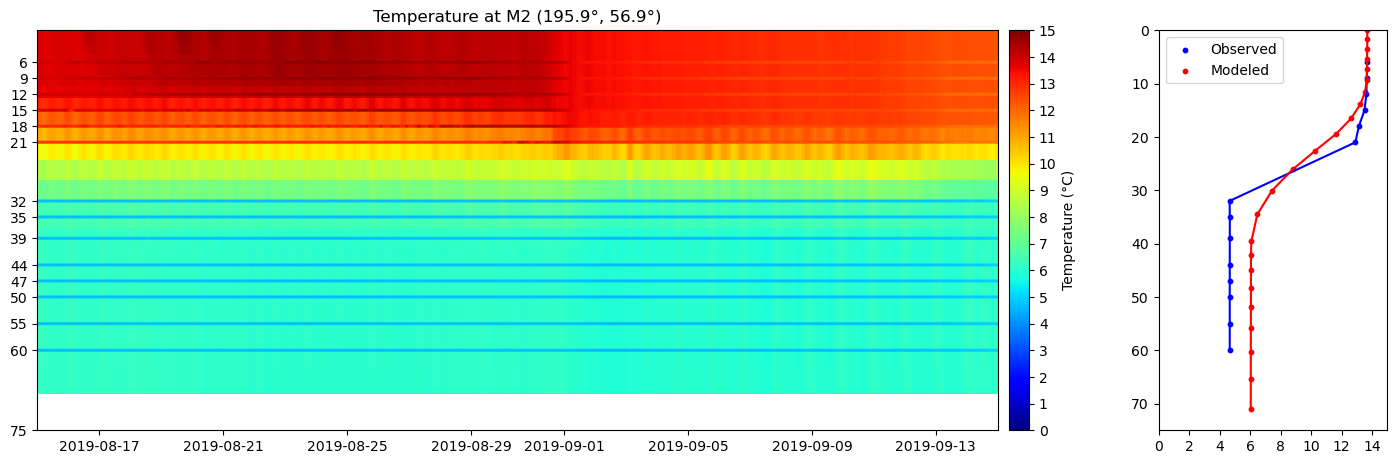

In [12]:
# for i,n in enumerate(data_name):
i=0
n=data_name[i]
#OBS DATA
ds = xr.open_dataset(path + f'20250211_BeringSeaMoorings/{data[i]}')
obs = ds[var].sel(time=slice(start_date, end_date))
depth_obs = ds['depth']
time_obs = ds['time'].sel(time=slice(start_date, end_date))

#MODEL DATA
model = xr.open_dataset(path+"merged_final.nc")
model = model.sel(time=slice(start_date, end_date))
zC=np.array(model.zCoordinates[:,i,:])
temp=np.array(model.temperature[:,i,:])
salt=np.array(model.salinity[:,i,:])
hX=np.array(model.horizontalVelX[:,i,:])
hY=np.array(model.horizontalVelY[:,i,:])
time=np.array(model.time)

zC = zC.reshape(-1, zC.shape[-1])
temp = temp.reshape(-1, temp.shape[-1])
salt = salt.reshape(-1, salt.shape[-1])
hX = hX.reshape(-1, hX.shape[-1])
hY = hY.reshape(-1, hY.shape[-1])

depth = np.mean(zC, axis=0)
#depth = np.nan_to_num(zC[-1, :], nan=0)
depth = np.nan_to_num(depth, nan=0)

if var == "salinity":
    minv = 31.5#obs.min()#min(obs.min(),np.nanmin(salt))
    maxv = 32.5#obs.max()#max(obs.max(),np.nanmax(salt))
    model = salt
if var == "temperature":
    minv = 0#min(obs.min(),np.nanmin(temp))
    maxv = 15#max(obs.max(),np.nanmax(temp))
    model = temp
if var == "u_comp_current":
    minv = -1
    maxv = 1
    model = hX
    obs = obs.T/100
if var == "v_comp_current":
    minv = -1
    maxv = 1
    model = hY
    obs = obs.T/100

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [5, 1]})

c1 = ax.pcolormesh(time, depth*-1, model.transpose(), cmap='jet', shading='nearest', vmin=minv, vmax=maxv)
x, y = np.meshgrid(obs['time'], depth_obs)
scatter = ax.scatter(x, y, c=obs, cmap='jet', alpha=0.5, vmin=minv, vmax=maxv, s=2)

# Invert y-axis and set limits
ax.set_ylim(0, 75)
ax.set_xlim(start_date, end_date)
ax.invert_yaxis()

non_nan_indices = ~np.isnan(np.array(obs))
result = y[non_nan_indices]
moor_d = np.unique(result.ravel())
moor_d = np.append(moor_d,[75])
ax.set_yticks(moor_d)
# Add colorbars
if var == "temperature":
    cbar = fig.colorbar(c1, ax=ax,label='Temperature (°C)', pad=0.01)
    tick_step = 1
    colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
    cbar.set_ticks(colorbar_ticks)
if var == "salinity":
    cbar = fig.colorbar(c1, ax=ax,label='Salinity (PSU)', pad=0.01)
    tick_step = .25
    colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
    cbar.set_ticks(colorbar_ticks)
if var == "u_comp_current":
    cbar = fig.colorbar(c1, ax=ax,label='Horizontal X Velocities (m/s)', pad=0.01)
    tick_step = .25
    colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
    cbar.set_ticks(colorbar_ticks)
if var == "v_comp_current":
    cbar = fig.colorbar(c1, ax=ax,label='Horizontal Y Velocities (m/s)', pad=0.01)
    tick_step = .25
    colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
    cbar.set_ticks(colorbar_ticks)

ax.set_title(f"{var.capitalize()} at {n} ({data_coord[i][0]:.1f}°, {data_coord[i][1]:.1f}°)")

# Second subplot: scatter plot of time-averaged modeled vs observed data
avg_obs = np.nanmean(obs, axis=1)  # Average across the time axis (axis=1) for observed data
avg_model = np.nanmean(model, axis=0)  # Average across the time axis (axis=0) for model data

sorted_depth_obs, sorted_avg_obs = zip(*sorted(zip(depth_obs, avg_obs)))
sorted_depth, sorted_avg_model = zip(*sorted(zip(depth*-1, avg_model)))

ax2.scatter(avg_obs, depth_obs, label='Observed', color='b', s=10)
ax2.scatter(avg_model, depth*-1, label='Modeled', color='r', s=10)

sorted_avg_obs =  np.array(sorted_avg_obs)
sorted_depth_obs = np.array(sorted_depth_obs)
sorted_avg_model =  np.array(sorted_avg_model)
sorted_depth = np.array(sorted_depth)

ax2.plot(sorted_avg_obs[~np.isnan(sorted_avg_obs)], sorted_depth_obs[~np.isnan(sorted_avg_obs)], color='b')  # Line for observed
ax2.plot(sorted_avg_model[~np.isnan(sorted_avg_model)], sorted_depth[~np.isnan(sorted_avg_model)], color='r')  # Line for modeled

ax2.set_ylim(0, 75)
ax2.invert_yaxis()

ax2.set_xlim(minv, maxv)
ax2.set_xticks(colorbar_ticks[::2])
ax2.legend()

plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, hspace=0.0) 

# fig.savefig(path+f'mooring_plots/{sd}_{ed}{n}_{var}.jpeg'.format(n))
# plt.clf()
plt.show()

In [225]:
sorted_depth_obs[~np.isnan(sorted_avg_obs)]

array([ 6.,  9., 12., 15., 18., 21., 32., 35., 39., 44., 47., 50., 55.,
       60.])

In [160]:
avg_obs.shape

(73,)

In [161]:
avg_model.shape

(51,)

In [162]:
obs.shape

(73, 745)

In [163]:
model.shape

(745, 51)

In [165]:
depth_obs

array([ 0.   ,  1.   ,  2.   ,  3.   ,  4.   ,  5.   ,  6.   ,  7.   ,
        8.   ,  9.   ,  9.019, 10.   , 11.   , 12.   , 13.   , 14.   ,
       15.   , 16.   , 17.   , 18.   , 19.   , 20.   , 21.   , 22.   ,
       23.   , 24.   , 24.5  , 25.   , 26.   , 27.   , 27.5  , 28.   ,
       29.   , 30.   , 30.071, 31.   , 32.   , 33.   , 34.   , 35.   ,
       36.   , 37.5  , 38.   , 39.   , 40.   , 41.   , 42.   , 43.   ,
       44.   , 45.   , 46.   , 47.   , 48.   , 49.   , 50.   , 51.   ,
       52.   , 53.   , 54.   , 55.   , 56.   , 57.   , 58.   , 59.   ,
       60.   , 61.   , 62.   , 63.   , 64.   , 65.   , 66.   , 67.   ,
       69.   ])

In [166]:
depth

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       -71.        , -65.39648   , -60.382885  , -55.894592  ,
       -51.873913  , -48.269253  , -45.03425   , -42.127415  ,
       -39.5115    , -34.505146  , -30.058378  , -26.097258  ,
       -22.556381  , -19.377575  , -16.50894   , -13.903862  ,
       -11.520291  ,  -9.319972  ,  -7.2678614 ,  -5.3314037 ,
        -3.4798937 ,  -1.6843213 ,   0.08352581], dtype=float32)

C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_3700\353957503.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c1 = ax.pcolormesh(time, depth*-1, model.transpose(), cmap='jet', shading='nearest', vmin=minv, vmax=maxv)
C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_3700\353957503.py:35: RuntimeWarning: Mean of empty slice
  avg_obs = np.nanmean(obs, axis=1)  # Average across the time axis (axis=1) for observed data
C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_3700\353957503.py:38: RuntimeWarning: Mean of empty slice
  avg_model = np.nanmean(model, axis=0)  # Average across the time axis (axis=0) for model data


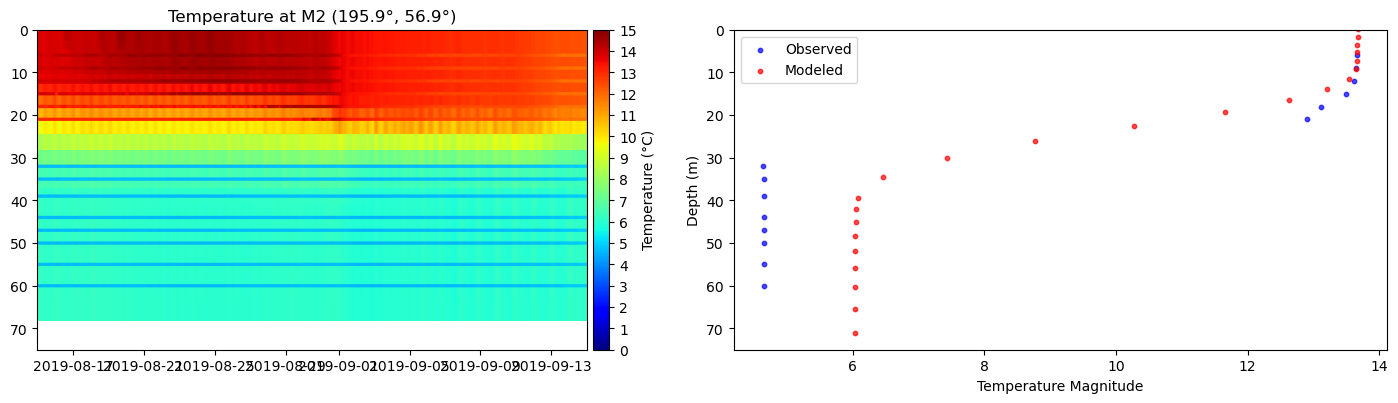

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've already defined variables such as 'model', 'obs', 'depth', etc.

# Create a figure with 2 subplots: the original plot and a new one for the scatter plot
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Original plot: pcolormesh and scatter plot (same as your existing code)
c1 = ax.pcolormesh(time, depth*-1, model.transpose(), cmap='jet', shading='nearest', vmin=minv, vmax=maxv)
x, y = np.meshgrid(obs['time'], depth_obs)
scatter = ax.scatter(x, y, c=obs, cmap='jet', alpha=0.5, vmin=minv, vmax=maxv, s=2)

ax.set_ylim(0, 75)
ax.set_xlim(start_date, end_date)
ax.invert_yaxis()

# Add colorbar for the first plot
if var == "temperature":
    cbar = fig.colorbar(c1, ax=ax, label='Temperature (°C)', pad=0.01)
    tick_step = 1
    colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
    cbar.set_ticks(colorbar_ticks)
if var == "salinity":
    cbar = fig.colorbar(c1, ax=ax, label='Salinity (PSU)', pad=0.01)
    tick_step = .25
    colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
    cbar.set_ticks(colorbar_ticks)

ax.set_title(f"{var.capitalize()} at {n} ({data_coord[i][0]:.1f}°, {data_coord[i][1]:.1f}°)")

# Second subplot: scatter plot of time-averaged modeled vs observed data

# Average the observed data along the time axis (axis=1) to get an average at each depth
avg_obs = np.nanmean(obs, axis=1)  # Average across the time axis (axis=1) for observed data

# Average the model data along the time axis (axis=0) to get an average at each depth
avg_model = np.nanmean(model, axis=0)  # Average across the time axis (axis=0) for model data

# Scatter plot on ax2
ax2.scatter(avg_obs, depth_obs, label='Observed', color='b', s=10, alpha=0.7)
ax2.scatter(avg_model, depth*-1, label='Modeled', color='r', s=10, alpha=0.7)

ax2.set_xlabel(f'{var.capitalize()} Magnitude')
ax2.set_ylabel('Depth (m)')
ax2.set_ylim(0, 75)
ax2.invert_yaxis()

# Optional: add legend
ax2.legend()

# Adjust layout for better visibility
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9)

# Display the plot
plt.show()


C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_14460\2916898134.py:10: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c1 = ax.pcolormesh(time, depth*-1, model.transpose(), cmap='jet', shading='nearest', vmin=minv, vmax=maxv)
C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_14460\2916898134.py:35: RuntimeWarning: Mean of empty slice
  avg_obs = np.nanmean(obs, axis=1)  # Average across the time axis (axis=1) for observed data
C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_14460\2916898134.py:38: RuntimeWarning: Mean of empty slice
  avg_model = np.nanmean(model, axis=0)  # Average across the time axis (axis=0) for model data


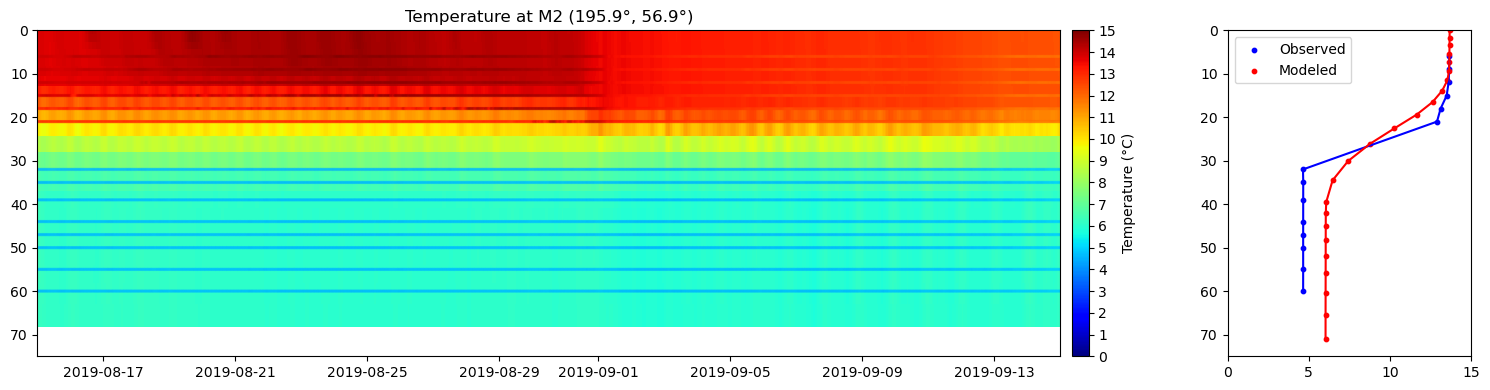

In [219]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you've already defined variables such as 'model', 'obs', 'depth', etc.

# Create a figure with 2 subplots: the original plot and a new one for the scatter plot
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'width_ratios': [5, 1]})

# Original plot: pcolormesh and scatter plot (same as your existing code)
c1 = ax.pcolormesh(time, depth*-1, model.transpose(), cmap='jet', shading='nearest', vmin=minv, vmax=maxv)
x, y = np.meshgrid(obs['time'], depth_obs)
scatter = ax.scatter(x, y, c=obs, cmap='jet', alpha=0.5, vmin=minv, vmax=maxv, s=2)

ax.set_ylim(0, 75)
ax.set_xlim(start_date, end_date)
ax.invert_yaxis()

# Add colorbar for the first plot
if var == "temperature":
    cbar = fig.colorbar(c1, ax=ax, label='Temperature (°C)', pad=0.01)
    tick_step = 1
    colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
    cbar.set_ticks(colorbar_ticks)
if var == "salinity":
    cbar = fig.colorbar(c1, ax=ax, label='Salinity (PSU)', pad=0.01)
    tick_step = .25
    colorbar_ticks = np.arange(minv - minv % tick_step, maxv + tick_step, tick_step)
    cbar.set_ticks(colorbar_ticks)

ax.set_title(f"{var.capitalize()} at {n} ({data_coord[i][0]:.1f}°, {data_coord[i][1]:.1f}°)")

# Second subplot: scatter plot of time-averaged modeled vs observed data

# Average the observed data along the time axis (axis=1) to get an average at each depth
avg_obs = np.nanmean(obs, axis=1)  # Average across the time axis (axis=1) for observed data

# Average the model data along the time axis (axis=0) to get an average at each depth
avg_model = np.nanmean(model, axis=0)  # Average across the time axis (axis=0) for model data

# Sort depth, observed and modeled data to make sure the line is continuous and ordered by depth
sorted_depth_obs, sorted_avg_obs = zip(*sorted(zip(depth_obs, avg_obs)))
sorted_depth, sorted_avg_model = zip(*sorted(zip(depth*-1, avg_model)))

# Scatter plot on ax2
ax2.scatter(avg_obs, depth_obs, label='Observed', color='b', s=10)
ax2.scatter(avg_model, depth*-1, label='Modeled', color='r', s=10)

# Plot lines connecting the points
sorted_avg_obs =  np.array(sorted_avg_obs)
sorted_depth_obs = np.array(sorted_depth_obs)
sorted_avg_model =  np.array(sorted_avg_model)
sorted_depth = np.array(sorted_depth)

ax2.plot(sorted_avg_obs[~np.isnan(sorted_avg_obs)], sorted_depth_obs[~np.isnan(sorted_avg_obs)], color='b')  # Line for observed
ax2.plot(sorted_avg_model[~np.isnan(sorted_avg_model)], sorted_depth[~np.isnan(sorted_avg_model)], color='r')  # Line for modeled

# ax2.set_xlabel(f'{var.capitalize()} Magnitude')
# ax2.set_ylabel('Depth (m)')
ax2.set_ylim(0, 75)
ax2.invert_yaxis()

ax2.set_xlim(minv, maxv)
ax2.legend()

# Adjust layout for better visibility
plt.tight_layout()
# plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9)

# Display the plot
plt.show()


In [220]:
sorted_depth_obs[~np.isnan(sorted_avg_obs)]

array([ 6.,  9., 12., 15., 18., 21., 32., 35., 39., 44., 47., 50., 55.,
       60.])

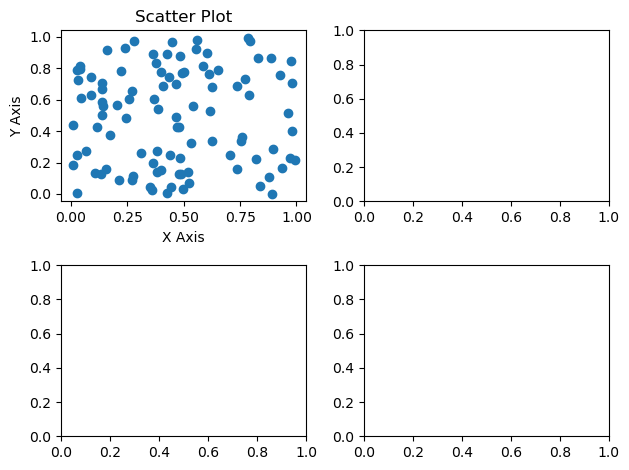

In [214]:
import matplotlib.pyplot as plt
import numpy as np

# Example data for scatter plot
x = np.random.rand(100)
y = np.random.rand(100)

# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2)

# Select the specific subplot for the scatter plot (for example, top-left)
ax = axs[0, 0]

# Scatter plot on the selected subplot
ax.scatter(x, y)

# Set labels and title for the scatter plot
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_title('Scatter Plot')

# Adjust layout to make sure everything fits
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
z

In [158]:
depth_obs

<xarray.DataArray 'depth' (depth: 73)> Size: 584B
array([ 0.   ,  1.   ,  2.   ,  3.   ,  4.   ,  5.   ,  6.   ,  7.   ,  8.   ,
        9.   ,  9.019, 10.   , 11.   , 12.   , 13.   , 14.   , 15.   , 16.   ,
       17.   , 18.   , 19.   , 20.   , 21.   , 22.   , 23.   , 24.   , 24.5  ,
       25.   , 26.   , 27.   , 27.5  , 28.   , 29.   , 30.   , 30.071, 31.   ,
       32.   , 33.   , 34.   , 35.   , 36.   , 37.5  , 38.   , 39.   , 40.   ,
       41.   , 42.   , 43.   , 44.   , 45.   , 46.   , 47.   , 48.   , 49.   ,
       50.   , 51.   , 52.   , 53.   , 54.   , 55.   , 56.   , 57.   , 58.   ,
       59.   , 60.   , 61.   , 62.   , 63.   , 64.   , 65.   , 66.   , 67.   ,
       69.   ])
Coordinates:
  * depth    (depth) float64 584B 0.0 1.0 2.0 3.0 4.0 ... 65.0 66.0 67.0 69.0
Attributes:
    _CoordinateAxisType:     Height
    _CoordinateZisPositive:  down
    actual_range:            [ 0. 69.]
    axis:                    Z
    ioos_category:           Location
    long_name:               Depth
    positive:                down
    standard_name:           depth
    units:                   m

In [7]:
ds = xr.open_dataset(path + f'20250211_BeringSeaMoorings/{data_TS[3]}')

C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\xarray\conventions.py:200: SerializationWarning: variable 'temperature' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\xarray\conventions.py:200: SerializationWarning: variable 'pressure' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
C:\Users\Felicio.Cassalho\.conda\envs\ak_vis\lib\site-packages\xarray\conventions.py:200: SerializationWarning: variable 'salinity' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [8]:
start_date = '2019-07-01T13:00:00.000000000'
end_date = '2019-11-01T12:00:00.000000000'  
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

In [9]:
obs = ds[var].sel(time=slice(start_date, end_date))
depth_obs = ds['depth']
time_obs = ds['time'].sel(time=slice(start_date, end_date))
latitude = ds['latitude'].sel(time=slice(start_date, end_date)).max()
longitude = ds['longitude'].sel(time=slice(start_date, end_date)).max()

In [10]:
idx = 3
model = xr.open_dataset(path+"merged_final.nc")

In [11]:
zC=np.array(model.zCoordinates[:,idx,:])
temp=np.array(model.temperature[:,idx,:])
salt=np.array(model.salinity[:,idx,:])
time=np.array(model.time)

In [12]:
zC = zC.reshape(-1, zC.shape[-1])
temp = temp.reshape(-1, temp.shape[-1])
salt = salt.reshape(-1, salt.shape[-1])

In [13]:
depth = np.mean(zC, axis=0)
#depth = np.nan_to_num(zC[-1, :], nan=0)
depth = np.nan_to_num(depth, nan=0)

if var == "salinity":
    minv = obs.min()#min(obs.min(),np.nanmin(salt))
    maxv = obs.max()#max(obs.max(),np.nanmax(salt))
    model = salt
if var == "temperature":
    minv = min(obs.min(),np.nanmin(temp))
    maxv = max(obs.max(),np.nanmax(temp))
    model = temp

In [14]:
longitudes, latitudes =np.array([longitude,latitude])[0],np.array([longitude,latitude])[-1]

C:\Users\Felicio.Cassalho\AppData\Local\Temp\1\ipykernel_15672\213982229.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c1 = ax.pcolormesh(time, depth*-1, model.transpose(), cmap='jet', shading='nearest', vmin=minv, vmax=maxv)


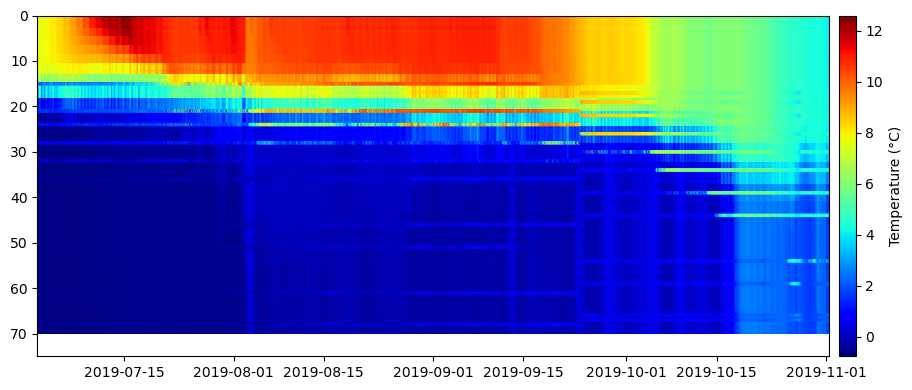

In [15]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import cartopy.crs as ccrs
# import numpy as np
# import cartopy.feature as cfeature

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Plot the first pcolormesh (same as your existing code)
c1 = ax.pcolormesh(time, depth*-1, model.transpose(), cmap='jet', shading='nearest', vmin=minv, vmax=maxv)

# Plot the second pcolormesh on top, with transparency (same as your existing code)
x, y = np.meshgrid(obs['time'], depth_obs)
scatter = ax.scatter(x, y, c=obs, cmap='jet', alpha=0.5, vmin=minv, vmax=maxv, s=2)

# Invert y-axis and set limits
plt.ylim(0, 75)
plt.xlim(start_date, end_date)
plt.gca().invert_yaxis()

# Add colorbars
if var == "temperature":
    fig.colorbar(c1, ax=ax,label='Temperature (°C)', pad=0.01)
if var == "salinity":
    fig.colorbar(c1, ax=ax,label='Salinity (PSU)', pad=0.01)
    
# # Add inset map to the figure using Cartopy
# # Create inset axes inside the main axes for the small map
# axins = fig.add_axes([0.005, 0.15, 0.2, 0.2], projection=ccrs.PlateCarree())  # Create a GeoAxes for Cartopy
# # Set the extent to zoom into the region of interest
# axins.set_extent([-180, -155, 50, 70], crs=ccrs.PlateCarree())  # Adjust the extent based on your data
# # Add map features
# axins.stock_img()  # Add a background image
# axins.coastlines()  # Add coastlines

# Plot the latitude and longitude on the inset map
# axins.scatter(longitudes, latitudes, color='red', s=20, label="Data Point", transform=ccrs.PlateCarree())
# axins.legend()

# Show the plot
plt.tight_layout()
plt.show()